In [71]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil, math, sys
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import SGD
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.applications import inception_v3 as inc_net
from keras.applications.imagenet_utils import decode_predictions
from skimage.segmentation import mark_boundaries

In [2]:
import skimage
print(skimage.__version__)

0.16.2


# X-ray Classification Model
Note: This notebook is mostly a copy of MaidenVoyage and UpdateValidation but with the package lime

In [3]:
%load_ext autoreload
%autoreload 2
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

## Overview
I have been tasked to build a deep neural network to train on a data set of x-ray images of pediatric patients to identify whether or not they have pneumonia. This data is sourced from Kermany et al. on Mendeley, however I personally used a version on Kaggle due to it being easier to use. The data originally consists of 5216 images in the training set, 624 in the test set, and 16 for the validation set. 

First I set up the paths and transfered images from the validation set to the test set.

In [25]:
train_path = os.path.join('chest_xray', 'train')
test_path = os.path.join('chest_xray', 'test')
val_path = os.path.join('chest_xray', 'val')

test_pos_path = os.path.join(test_path, 'PNEUMONIA')
test_neg_path = os.path.join(test_path, 'NORMAL')
val_pos_path = os.path.join(val_path, 'PNEUMONIA')
val_neg_path = os.path.join(val_path, 'NORMAL')

test_pos_names = os.listdir(test_pos_path)
test_neg_names = os.listdir(test_neg_path)

pos_sample_size = math.ceil(0.2*len(test_pos_names))
neg_sample_size = math.ceil(0.2*len(test_neg_names))

test_pos_selected = np.random.choice(test_pos_names, replace=False, size=pos_sample_size)
test_neg_selected = np.random.choice(test_neg_names, replace=False, size=neg_sample_size)

src_pos_imgs = [os.path.join(test_pos_path, name) for name in test_pos_selected]
src_neg_imgs = [os.path.join(test_neg_path, name) for name in test_neg_selected]

val_pos_imgs = [os.path.join(val_pos_path, name) for name in test_pos_selected]
val_neg_imgs = [os.path.join(val_neg_path, name) for name in test_neg_selected]


In [14]:
with open('src_pos_imgs.txt', "w") as file :
    file.write("\n".join(src_pos_imgs))
with open('src_neg_imgs.txt', "w") as file :
    file.write("\n".join(src_neg_imgs))
with open('val_pos_imgs.txt', "w") as file :
    file.write("\n".join(val_pos_imgs))
with open('val_neg_imgs.txt', "w") as file :
    file.write("\n".join(val_neg_imgs))

Run cell below to add images to validation set

In [18]:
for src, dest in zip(src_pos_imgs, val_pos_imgs):
    shutil.move(src, dest)
for src, dest in zip(src_neg_imgs, val_neg_imgs):
    shutil.move(src, dest)

Run cell below to take images back from validation set

In [15]:
for src, dest in zip(src_pos_imgs, val_pos_imgs):
    shutil.move(dest, src)
for src, dest in zip(src_neg_imgs, val_neg_imgs):
    shutil.move(dest, src)

In [5]:
datagen = ImageDataGenerator()

train_gen = datagen.flow_from_directory(train_path)
test_gen = datagen.flow_from_directory(test_path)
val_gen = datagen.flow_from_directory(val_path)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 141 images belonging to 2 classes.


Using SGD for my optimizer for all of my models. I tuned the learning rate to 1e-5.

In [6]:
opt = SGD(learning_rate=1*10**-5)

## Methods
I am going through and checking different deep neural network architectures to see which one works best with the data. I ran into the issue that I didnt have enough images in my validation set so I brought some of the test images over in order to better interpret how my models perform. I ended up with 141 images for my validation set. After choosing which architecture to use I tune it to do my best to get the highest accuracy without overfitting on the data. I then used the package lime to see what parts of the images were being used to predict whether or not a patient has pneumonia.

In [15]:
def visualize_training_results(results):
    """Function that graphs and displays both loss and accuracy for a neural networks history.
    Orginal code from Deeper-Neural-Networks-lab"""
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

I set up my baseline model in order to make sure everything is running smoothly before running my more complicated networks. The results were very inconclusive but the model did what it was supposed to do.

In [8]:
def baseline_model(image_shape):
    model_layers = [
        layers.Input(image_shape),
        layers.Flatten(),
        layers.Dense(24, activation='relu'),
        layers.Dense(2, activation='sigmoid')
    ]
    model = Sequential(model_layers)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [23]:

baseline_model = baseline_model(train_gen.image_shape)
results_1 = baseline_model.fit(train_gen, validation_data=val_gen, epochs=25)

Epoch 1/25
163/163 [==============================] - 85s 517ms/step - loss: 4.5416 - accuracy: 0.7412 - val_loss: 0.6938 - val_accuracy: 0.6099
Epoch 2/25
163/163 [==============================] - 83s 509ms/step - loss: 0.6932 - accuracy: 0.7431 - val_loss: 0.6931 - val_accuracy: 0.6099
Epoch 3/25
163/163 [==============================] - 82s 501ms/step - loss: 0.6930 - accuracy: 0.7431 - val_loss: 0.6934 - val_accuracy: 0.6099
Epoch 4/25
163/163 [==============================] - 80s 490ms/step - loss: 0.6929 - accuracy: 0.7431 - val_loss: 0.6935 - val_accuracy: 0.6099
Epoch 5/25
163/163 [==============================] - 79s 486ms/step - loss: 0.6930 - accuracy: 0.7431 - val_loss: 0.6930 - val_accuracy: 0.6099
Epoch 6/25
163/163 [==============================] - 79s 486ms/step - loss: 0.6928 - accuracy: 0.7431 - val_loss: 0.6930 - val_accuracy: 0.6099
Epoch 7/25
163/163 [==============================] - 80s 490ms/step - loss: 0.6929 - accuracy: 0.7431 - val_loss: 0.6930 - val_ac

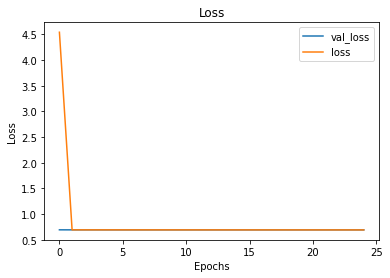

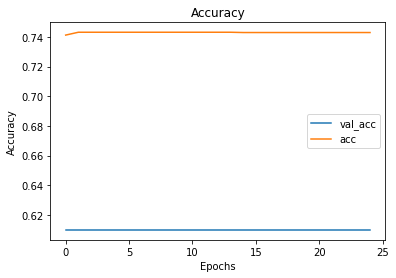

In [24]:
visualize_training_results(results_1)

My next model is a simple convolution network. I ended up with over 16 million trainable parameters and a lot of evidence of overfitting with my validation loss hovering around 10 while the loss approaches 0.  

In [25]:
def conv_1(image_shape):
    these_layers = [
        layers.Input(image_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(2, activation='sigmoid')
    ]
    model = Sequential(these_layers)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [26]:
model_2 = conv_1(train_gen.image_shape)
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 516128)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                16516128  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 16,517,090
Trainable params: 16,517,090
Non-trainable params: 0
_________________________________________________________________


In [27]:
results_2 = model_2.fit(train_gen, validation_data=val_gen, epochs=25)

Epoch 1/25
163/163 [==============================] - 145s 874ms/step - loss: 243.5777 - accuracy: 0.8146 - val_loss: 12.2136 - val_accuracy: 0.7447
Epoch 2/25
163/163 [==============================] - 139s 849ms/step - loss: 0.9749 - accuracy: 0.8838 - val_loss: 9.6292 - val_accuracy: 0.7518
Epoch 3/25
163/163 [==============================] - 137s 835ms/step - loss: 0.6316 - accuracy: 0.8974 - val_loss: 9.7324 - val_accuracy: 0.7801
Epoch 4/25
163/163 [==============================] - 137s 837ms/step - loss: 0.4563 - accuracy: 0.9095 - val_loss: 9.8053 - val_accuracy: 0.8014
Epoch 5/25
163/163 [==============================] - 134s 821ms/step - loss: 0.1814 - accuracy: 0.9206 - val_loss: 9.5397 - val_accuracy: 0.7518
Epoch 6/25
163/163 [==============================] - 134s 820ms/step - loss: 0.0953 - accuracy: 0.9350 - val_loss: 8.5770 - val_accuracy: 0.7801
Epoch 7/25
163/163 [==============================] - 137s 837ms/step - loss: 0.0761 - accuracy: 0.9480 - val_loss: 9.813

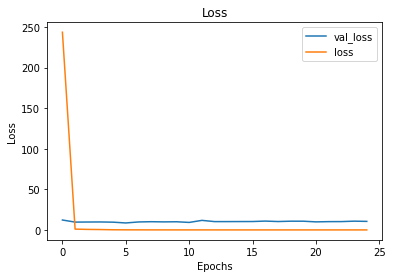

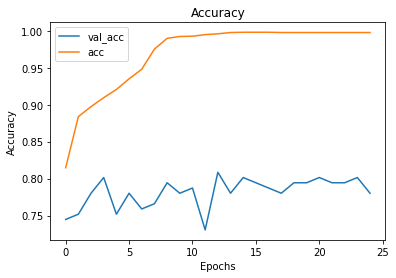

In [28]:
visualize_training_results(results_2)

My next model was the popular AlexNet. The normalization layers help with the overfitting but there is still some going on. The validation accuracy reached to 72% which isn't bad.

In [29]:
def AlexNet(image_shape):
    model_layers = [
        layers.Input(image_shape),
        layers.Conv2D(24, (11,11), activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3)),
        layers.Conv2D(64, (5,5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3)),
        layers.Conv2D(96, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(96, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3)),
        layers.Flatten(),
        layers.Dense(192, activation='relu'),
        layers.Dropout(.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(.3),
        layers.Dense(2, activation='sigmoid')
    ]
    
    model = Sequential(model_layers)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [30]:
model_3 = AlexNet(train_gen.image_shape)
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 246, 246, 24)      8736      
_________________________________________________________________
batch_normalization (BatchNo (None, 246, 246, 24)      96        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 82, 82, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 82, 82, 64)        38464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 82, 82, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 96)       

In [31]:
results_3 = model_3.fit(train_gen, validation_data=val_gen, epochs=25)

Epoch 1/25
163/163 [==============================] - 876s 5s/step - loss: 1.0879 - accuracy: 0.4291 - val_loss: 0.6983 - val_accuracy: 0.5603
Epoch 2/25
163/163 [==============================] - 866s 5s/step - loss: 1.0074 - accuracy: 0.4624 - val_loss: 0.7086 - val_accuracy: 0.6241
Epoch 3/25
163/163 [==============================] - 856s 5s/step - loss: 0.9840 - accuracy: 0.4799 - val_loss: 0.6895 - val_accuracy: 0.6596
Epoch 4/25
163/163 [==============================] - 853s 5s/step - loss: 0.9294 - accuracy: 0.5205 - val_loss: 0.6781 - val_accuracy: 0.6667
Epoch 5/25
163/163 [==============================] - 865s 5s/step - loss: 0.8845 - accuracy: 0.5562 - val_loss: 0.6589 - val_accuracy: 0.7234
Epoch 6/25
163/163 [==============================] - 860s 5s/step - loss: 0.8800 - accuracy: 0.5537 - val_loss: 0.6504 - val_accuracy: 0.6950
Epoch 7/25
163/163 [==============================] - 856s 5s/step - loss: 0.8521 - accuracy: 0.5836 - val_loss: 0.6547 - val_accuracy: 0.6667

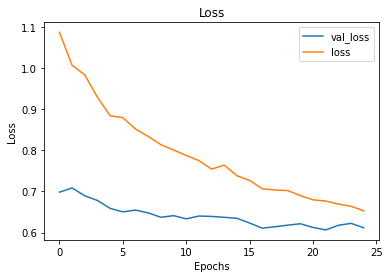

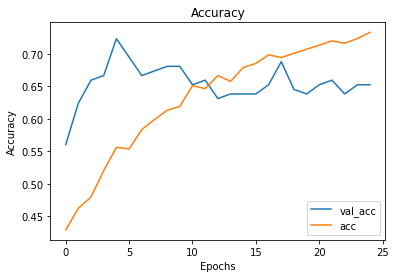

In [32]:
visualize_training_results(results_3)

## Results
The model that performed the best ended up being a simple residual network. I tried to expand the res-net [here]('FinalModel.ipynb') in order to better predict but ended up overloading my cpu and was unable to run it. I ended up only being able to generate approx. 75,000 trainable parameters compared to the 2,000,000 trainable parameters I generated with the simple res-net. With a validation accuracy of 78% the simple res-net is the best choice to predict whether or not a patient has pneumonia.

In [9]:
from tensorflow.keras import Model

def SimpleResNet(image_shape):
    input_layer = layers.Input(image_shape)
    
    X = layers.Conv2D(16, (3,3), activation='relu')(input_layer)
    X = layers.BatchNormalization()(X)
    
    X_shortcut = X
    
    X = layers.Conv2D(16, (3,3), padding='same', activation='relu')(X)
    X = layers.BatchNormalization()(X)
    
    X = layers.Add()([X, X_shortcut]) #Skip Connection
    X = layers.Activation('relu')(X)
    X = layers.Flatten()(X)
    X = layers.Dense(2, activation='sigmoid')(X)
    
    model = Model(inputs=input_layer, outputs=X, name='ResNet')
    
    model.compile(loss='binary_crossentropy',
                 optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [10]:
model_4 = SimpleResNet(train_gen.image_shape)
model_4.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 254, 254, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 254, 254, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 254, 254, 16) 2320        batch_normalization[0][0]        
_____________________________________________________________________________________________

2021-10-15 11:09:14.413136: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
results_4 = model_4.fit(train_gen, validation_data=val_gen, epochs=8)

2021-10-15 13:15:36.339929: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/8
163/163 [==============================] - 284s 2s/step - loss: 0.4227 - accuracy: 0.8405 - val_loss: 0.6122 - val_accuracy: 0.7589
Epoch 2/8
163/163 [==============================] - 276s 2s/step - loss: 0.2290 - accuracy: 0.9327 - val_loss: 0.7114 - val_accuracy: 0.7660
Epoch 3/8
163/163 [==============================] - 272s 2s/step - loss: 0.1746 - accuracy: 0.9532 - val_loss: 0.7189 - val_accuracy: 0.7801
Epoch 4/8
163/163 [==============================] - 273s 2s/step - loss: 0.1472 - accuracy: 0.9594 - val_loss: 0.7538 - val_accuracy: 0.7872
Epoch 5/8
163/163 [==============================] - 278s 2s/step - loss: 0.1291 - accuracy: 0.9670 - val_loss: 0.7605 - val_accuracy: 0.7801
Epoch 6/8
163/163 [==============================] - 275s 2s/step - loss: 0.1160 - accuracy: 0.9684 - val_loss: 0.7698 - val_accuracy: 0.7872
Epoch 7/8
163/163 [==============================] - 281s 2s/step - loss: 0.1063 - accuracy: 0.9712 - val_loss: 0.7508 - val_accuracy: 0.8014
Epoch 

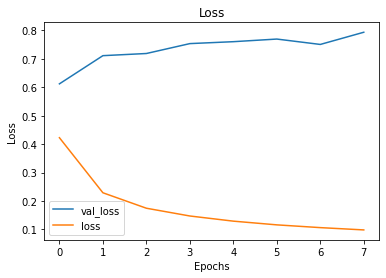

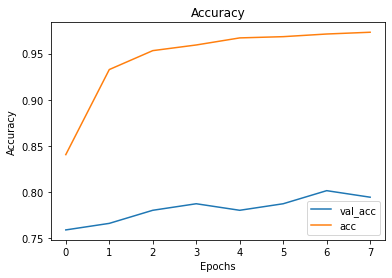

In [16]:
visualize_training_results(results_4)

In [37]:
baseline_model.save('/Users/ethan/FlatironTasks/phase_4/project/UpdatedModels/model_1')
model_2.save('/Users/ethan/FlatironTasks/phase_4/project/UpdatedModels/model_2')
model_3.save('/Users/ethan/FlatironTasks/phase_4/project/UpdatedModels/model_3')
model_4.save('/Users/ethan/FlatironTasks/phase_4/project/UpdatedModels/model_4')

INFO:tensorflow:Assets written to: /Users/ethan/FlatironTasks/phase_4/project/UpdatedModels/model_1/assets
INFO:tensorflow:Assets written to: /Users/ethan/FlatironTasks/phase_4/project/UpdatedModels/model_2/assets
INFO:tensorflow:Assets written to: /Users/ethan/FlatironTasks/phase_4/project/UpdatedModels/model_3/assets
INFO:tensorflow:Assets written to: /Users/ethan/FlatironTasks/phase_4/project/UpdatedModels/model_4/assets


/Users/ethan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [15]:
loaded_model = tf.keras.models.load_model('/Users/ethan/FlatironTasks/phase_4/project/UpdatedModels/model_4')

I used the package lime and the code from https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb in order to see which parts of the images are being used to predict.

In [44]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(256, 256))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)


In [57]:
pos_test_images = transform_img_fn([os.path.join(test_pos_path, names) for names in test_pos_names])
neg_test_images = transform_img_fn([os.path.join(test_neg_path, names) for names in test_neg_names])

In [62]:
images = np.concatenate((pos_test_images, neg_test_images), axis=0)
images.shape

(624, 256, 256, 3)

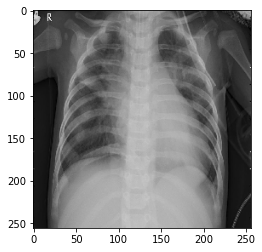

In [83]:
plt.imshow(images[0] / 2 + 0.5)
preds = model_4.predict(images)
explainer = lime_image.LimeImageExplainer()


In [77]:
explanation = explainer.explain_instance(images[0].astype('double'),\
                                         model_4.predict, top_labels=5,\
                                         hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

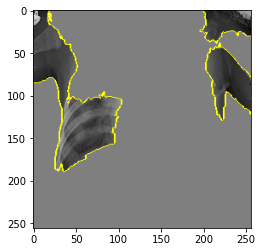

In [79]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

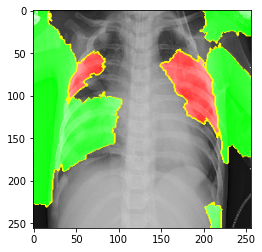

In [80]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

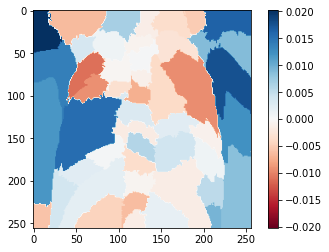

In [81]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# Next Step
The next step is to add regularization layers in order to combat overfitting which was found in nearly every model. Then the best idea would be to get in contact with a radiologist and go over all the lime results to make sure the model is using the correct parts of the images to predict. 